<a href="https://colab.research.google.com/github/NARAEIM/tp2-da/blob/jennlee/sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# library & dataset 불러오기

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.style.use("default")

sales = pd.read_csv('/content/drive/MyDrive/co_note/project/data/sales.csv')

Mounted at /content/drive


In [2]:
session_splt = pd.read_csv('/content/drive/MyDrive/co_note/project/data/buy_split_book.csv')
session_splt.head()

,session_id,event_name,event_time,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount,customer_id,quarter,old_session,booking_id
0,44122af0-0bf5-407b-b3ff-22c082c61426,HOMEPAGE,2016-10-09 21:17:34.380487+00:00,MOBILE,NaN,0,0,NaN,NaN,0.0,0,50.0,NaN,44122af0-0bf5-407b-b3ff-22c082c61426,097c5406-68c5-4ecc-8399-8745cb3ff0ca
1,44122af0-0bf5-407b-b3ff-22c082c61426,ADD_TO_CART,2016-10-09 21:28:40.380487+00:00,MOBILE,24639.0,1,255356,NaN,NaN,0.0,0,50.0,NaN,44122af0-0bf5-407b-b3ff-22c082c61426,097c5406-68c5-4ecc-8399-8745cb3ff0ca
2,44122af0-0bf5-407b-b3ff-22c082c61426,HOMEPAGE,2016-10-09 21:30:22.380487+00:00,MOBILE,NaN,0,0,NaN,NaN,0.0,0,50.0,NaN,44122af0-0bf5-407b-b3ff-22c082c61426,097c5406-68c5-4ecc-8399-8745cb3ff0ca
3,44122af0-0bf5-407b-b3ff-22c082c61426,HOMEPAGE,2016-10-09 21:42:14.380487+00:00,MOBILE,NaN,0,0,NaN,NaN,0.0,0,50.0,NaN,44122af0-0bf5-407b-b3ff-22c082c61426,097c5406-68c5-4ecc-8399-8745cb3ff0ca
4,44122af0-0bf5-407b-b3ff-22c082c61426,ITEM_DETAIL,2016-10-09 21:54:20.380487+00:00,MOBILE,NaN,0,0,NaN,NaN,0.0,0,50.0,NaN,44122af0-0bf5-407b-b3ff-22c082c61426,097c5406-68c5-4ecc-8399-8745cb3ff0ca


In [6]:
session_splt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12463004 entries, 0 to 12463003
Data columns (total 15 columns):
 #   Column           Dtype  
---  ------           -----  
 0   session_id       object 
 1   event_name       object 
 2   event_time       object 
 3   traffic_source   object 
 4   product_id       float64
 5   quantity         int64  
 6   item_price       int64  
 7   payment_status   float64
 8   search_keywords  object 
 9   promo_code       float64
 10  promo_amount     int64  
 11  customer_id      float64
 12  quarter          float64
 13  old_session      object 
 14  booking_id       object 
dtypes: float64(5), int64(3), object(7)
memory usage: 1.4+ GB


In [3]:
session_splt.session_id.nunique()

9318705

# sales dataset 생성

In [6]:
transaction = pd.read_csv('/content/drive/MyDrive/co_note/project/data/transaction_final.csv')
customer = pd.read_csv('/content/drive/MyDrive/co_note/project/data/customer_final.csv')

In [ ]:
# Sort the transaction dataframe by customer_id and created_at
transaction.sort_values(by=['customer_id', 'created_at'], inplace=True)

# Calculate the 'sales' column
sales = pd.DataFrame(transaction.groupby(['customer_id', 'booking_id']).total_amount.unique() - transaction.groupby(['customer_id', 'booking_id']).shipment_fee.unique())

# Reset index to get 'customer_id' and 'booking_id' as columns
sales = sales.reset_index()

# Merge with the original transaction dataframe to include additional columns
sales = pd.merge(sales, transaction[['customer_id', 'booking_id', 'created_at', 'total_amount', 'promo_amount', 'shipment_fee']], on=['customer_id', 'booking_id'], how='left')

# Display the resulting dataset
sales.head()

In [53]:
# Merge with the original transaction dataframe to include additional columns
sales = pd.merge(sales, customer[['customer_id', 'gender', 'age_now', 'first_join_date']], on=['customer_id'], how='left')

In [56]:
sales.drop_duplicates(subset='booking_id', inplace=True)

In [54]:
sales.head()

,customer_id,booking_id,created_at,total_amount,promo_amount,shipment_fee,sales,gender,age_now,first_join_date
0,3,0b3f17a4-f733-4eac-b9e9-37c039746e95,2020-05-31 05:45:52.844494+00:00,174717,3791,0,170926,M,36,2018-08-25
1,3,0fb5a9e6-f306-4c37-b7f0-992bc78064a7,2022-06-26 15:41:52.844494+00:00,189939,4240,0,185699,M,36,2018-08-25
2,3,1229bd35-7747-447a-a60b-02860bf7da7e,2021-07-25 10:24:57.844494+00:00,287523,0,0,287523,M,36,2018-08-25
3,3,163e447d-f2c2-4fac-b8a1-015eb01afd41,2020-06-28 06:31:43.844494+00:00,359032,1472,0,357560,M,36,2018-08-25
4,3,182774df-3cde-46cf-b302-4d93e0d94288,2021-01-10 07:56:16.844494+00:00,205436,4746,5000,195690,M,36,2018-08-25


In [57]:
sales.shape

(852582, 10)

In [46]:
sales.booking_id.duplicated().sum()

0

In [14]:
1254578-401996

852582

In [ ]:
sales['sales'] = sales['total_amount'] - sales['promo_amount'] - sales['shipment_fee']

In [ ]:
sales.drop(axis=0, index=None, columns='0', inplace=True, errors='raise')

In [ ]:
sales.info()

In [58]:
# sale dataset 저장
file_path = '/content/drive/MyDrive/co_note/project/data/sales.csv'
sales.to_csv(file_path, index=False)

# sales 전처리

In [2]:
display(sales.head(), sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852582 entries, 0 to 852581
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   customer_id      852582 non-null  int64 
 1   booking_id       852582 non-null  object
 2   created_at       852582 non-null  object
 3   total_amount     852582 non-null  int64 
 4   promo_amount     852582 non-null  int64 
 5   shipment_fee     852582 non-null  int64 
 6   sales            852582 non-null  int64 
 7   gender           852582 non-null  object
 8   age_now          852582 non-null  int64 
 9   first_join_date  852582 non-null  object
dtypes: int64(6), object(4)
memory usage: 65.0+ MB


,customer_id,booking_id,created_at,total_amount,promo_amount,shipment_fee,sales,gender,age_now,first_join_date
0,3,0b3f17a4-f733-4eac-b9e9-37c039746e95,2020-05-31 05:45:52.844494+00:00,174717,3791,0,170926,M,36,2018-08-25
1,3,0fb5a9e6-f306-4c37-b7f0-992bc78064a7,2022-06-26 15:41:52.844494+00:00,189939,4240,0,185699,M,36,2018-08-25
2,3,1229bd35-7747-447a-a60b-02860bf7da7e,2021-07-25 10:24:57.844494+00:00,287523,0,0,287523,M,36,2018-08-25
3,3,163e447d-f2c2-4fac-b8a1-015eb01afd41,2020-06-28 06:31:43.844494+00:00,359032,1472,0,357560,M,36,2018-08-25
4,3,182774df-3cde-46cf-b302-4d93e0d94288,2021-01-10 07:56:16.844494+00:00,205436,4746,5000,195690,M,36,2018-08-25


None

In [13]:
sales['created_at'] = pd.to_datetime(sales['created_at'])
sales['y_m'] = sales['created_at'].dt.to_period('M')

<ipython-input-13-3c8275dc2cd7>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sales['y_m'] = sales['created_at'].dt.to_period('M')


In [4]:
sales[sales['y_m'] == '2016-06']['customer_id'].nunique()

1

In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852582 entries, 0 to 852581
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   customer_id      852582 non-null  int64              
 1   booking_id       852582 non-null  object             
 2   created_at       852582 non-null  datetime64[ns, UTC]
 3   total_amount     852582 non-null  int64              
 4   promo_amount     852582 non-null  int64              
 5   shipment_fee     852582 non-null  int64              
 6   sales            852582 non-null  int64              
 7   gender           852582 non-null  object             
 8   age_now          852582 non-null  int64              
 9   first_join_date  852582 non-null  object             
 10  y_m              852582 non-null  period[M]          
dtypes: datetime64[ns, UTC](1), int64(6), object(3), period[M](1)
memory usage: 71.6+ MB


# sales 분석

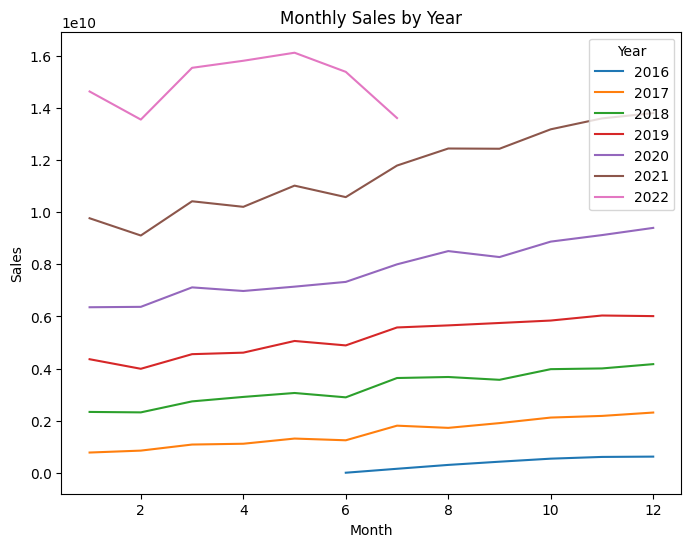

In [69]:
sales['year'] = sales['y_m'].dt.year
sales['month'] = sales['y_m'].dt.month

monthly_sales = sales.groupby(['year', 'month'])['sales'].sum().reset_index()

years = monthly_sales['year'].unique()

fig, ax = plt.subplots(figsize=(8, 6))

for year in years:
    year_data = monthly_sales[monthly_sales['year'] == year]
    ax.plot(year_data['month'], year_data['sales'], label=str(year))

ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Monthly Sales by Year')
ax.legend(title='Year')
plt.show()

<Axes: xlabel='y_m', ylabel='sales'>

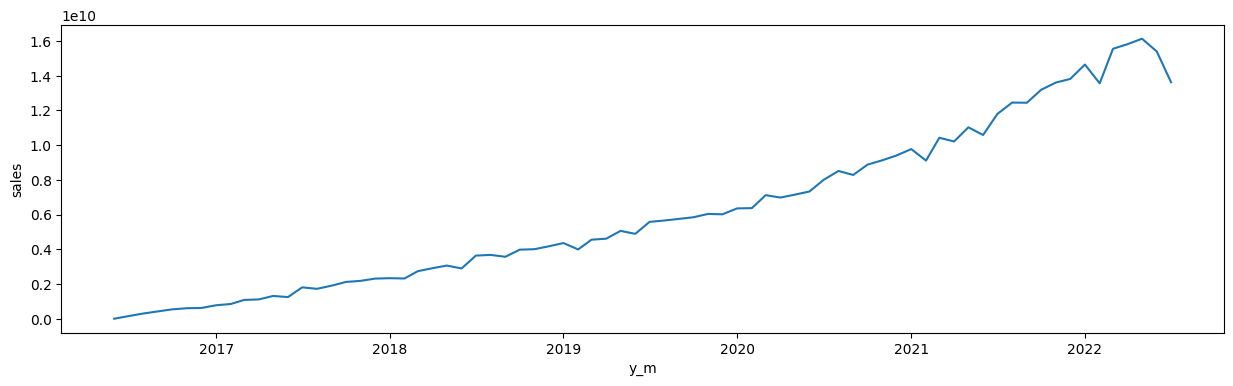

In [17]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(data=monthly_sales, x='y_m', y='sales', ax=ax)

In [ ]:
def plot_visitors(df):
  #index의 month를 x축으로 선택
  month = df.index.get_level_values('month').astype(str)

  # 방문객 수 데이터
  visitors = df[df.columns[0]]

  # 시계열 그래프 그리기
  plt.figure(figsize=(20, 6))
  plt.plot(month, visitors)
  plt.xlabel('Month')
  plt.ylabel('Visitors')
  plt.title(f'MONTHLY "{df.columns[0]}" PAGE VISITORS')
  plt.xticks(rotation=45)  # x축 라벨 회전
  return plt.show()

#객단가


## 월별 매출

In [14]:
monthly_sales = sales.groupby(sales['y_m'])['sales'].sum()
monthly_sales

y_m
2016-06         630795
2016-07      152067080
2016-08      300527207
2016-09      424014477
2016-10      540388728
              ...     
2022-03    15546610108
2022-04    15817357632
2022-05    16125996954
2022-06    15391398000
2022-07    13618235309
Freq: M, Name: sales, Length: 74, dtype: int64

In [15]:
monthly_sales_df = monthly_sales.to_frame(name='sales').reset_index()
monthly_sales_df

,y_m,sales
0,2016-06,630795
1,2016-07,152067080
2,2016-08,300527207
3,2016-09,424014477
4,2016-10,540388728
...,...,...
69,2022-03,15546610108
70,2022-04,15817357632
71,2022-05,16125996954
72,2022-06,15391398000


## 월별 unique 구매 session 수

In [4]:
# 구매한 경우: event_name == 'booking'
monthly_buy = session_splt[session_splt.event_name == 'BOOKING']
monthly_buy.shape

(852582, 15)

In [5]:
monthly_buy['event_time'] = pd.to_datetime(monthly_buy['event_time'])
monthly_buy_cnt = monthly_buy.groupby(monthly_buy['event_time'].dt.to_period('M'))['session_id'].nunique()
monthly_buy_cnt

<ipython-input-5-cd5dfac13239>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_buy['event_time'] = pd.to_datetime(monthly_buy['event_time'])
<ipython-input-5-cd5dfac13239>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_buy_cnt = monthly_buy.groupby(monthly_buy['event_time'].dt.to_period('M'))['session_id'].nunique()


event_time
2016-06        1
2016-07      296
2016-08      547
2016-09      717
2016-10      989
           ...  
2022-03    28801
2022-04    29237
2022-05    30084
2022-06    28587
2022-07    25162
Freq: M, Name: session_id, Length: 74, dtype: int64

In [6]:
monthly_buy_cnt_df = monthly_buy_cnt.to_frame(name='buy_cnt').reset_index()
monthly_buy_cnt_df

,event_time,buy_cnt
0,2016-06,1
1,2016-07,296
2,2016-08,547
3,2016-09,717
4,2016-10,989
...,...,...
69,2022-03,28801
70,2022-04,29237
71,2022-05,30084
72,2022-06,28587


In [20]:
monthly_buy_cnt_df.rename(columns={'event_time': 'y_m'}, inplace=True)

In [21]:
monthly_buy_cnt_df.head()

,y_m,buy_cnt
0,2016-06,1
1,2016-07,296
2,2016-08,547
3,2016-09,717
4,2016-10,989


## merge sales and buy session

In [22]:
merged_unit = monthly_buy_cnt_df.merge(monthly_sales_df, on='y_m')
merged_unit

,y_m,buy_cnt,sales
0,2016-06,1,630795
1,2016-07,296,152067080
2,2016-08,547,300527207
3,2016-09,717,424014477
4,2016-10,989,540388728
...,...,...,...
69,2022-03,28801,15546610108
70,2022-04,29237,15817357632
71,2022-05,30084,16125996954
72,2022-06,28587,15391398000


In [24]:
pd.options.display.float_format = '{:.2f}'.format

merged_unit['unit_price'] = merged_unit.sales / merged_unit.buy_cnt
merged_unit

,y_m,buy_cnt,sales,unit_price
0,2016-06,1,630795,630795.00
1,2016-07,296,152067080,513740.14
2,2016-08,547,300527207,549409.88
3,2016-09,717,424014477,591373.05
4,2016-10,989,540388728,546399.12
...,...,...,...,...
69,2022-03,28801,15546610108,539794.11
70,2022-04,29237,15817357632,541004.81
71,2022-05,30084,16125996954,536032.34
72,2022-06,28587,15391398000,538405.50


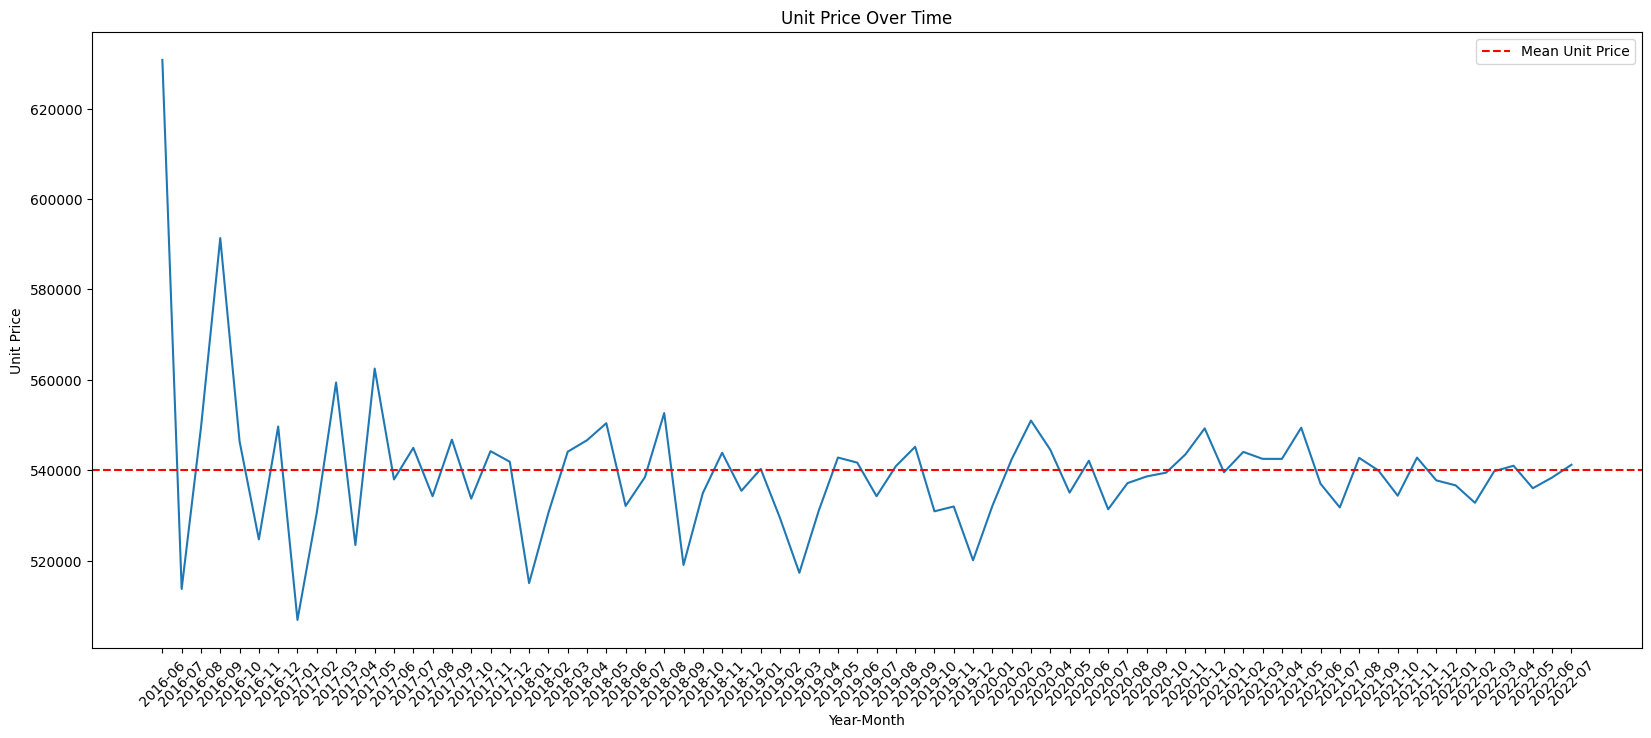

In [26]:
merged_unit['y_m'] = merged_unit['y_m'].astype(str)

# Plotting
plt.figure(figsize=(20, 8))

plt.plot(merged_unit['y_m'], merged_unit['unit_price'])

plt.xlabel('Year-Month')
plt.ylabel('Unit Price')
plt.title('Unit Price Over Time')

plt.xticks(rotation=45)

mean_unit_price = merged_unit['unit_price'].mean()
plt.axhline(mean_unit_price, color='red', linestyle='--', label='Mean Unit Price')

plt.legend(loc='upper right')

plt.show()

## 고객 수를 구하는 것은 객단가와 관련 없음

### 구매 고객 수 -> 객단가는 session 별로 구할 것, 고객 수는 객단가랑 관련 없음

In [7]:
monthly_cust_cnt = sales.groupby('y_m')['customer_id'].nunique()
monthly_cust_cnt

sales[sales['created_at'] < '2017-01-01']['customer_id'].nunique()

2488

In [8]:
monthly_cust_cnt_df = monthly_cust_cnt.to_frame(name='cus_cnt').reset_index()
monthly_cust_cnt_df

,y_m,cus_cnt
0,2016-06,1
1,2016-07,281
2,2016-08,485
3,2016-09,610
4,2016-10,806
...,...,...
69,2022-03,18236
70,2022-04,18449
71,2022-05,18089
72,2022-06,16815


In [29]:
monthly_cust_cnt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   y_m     74 non-null     period[M]
 1   sales   74 non-null     int64    
dtypes: int64(1), period[M](1)
memory usage: 1.3 KB


### 월별 매출 및 구매고객 수

In [13]:
merged_unit = monthly_cust_cnt_df.merge(monthly_sales_df, on='y_m')
merged_unit

,y_m,cus_cnt,sales
0,2016-06,1,630795
1,2016-07,281,152067080
2,2016-08,485,300527207
3,2016-09,610,424014477
4,2016-10,806,540388728
...,...,...,...
69,2022-03,18236,15546610108
70,2022-04,18449,15817357632
71,2022-05,18089,16125996954
72,2022-06,16815,15391398000


In [14]:
pd.options.display.float_format = '{:.2f}'.format

merged_unit['unit_price'] = merged_unit.sales / merged_unit.cus_cnt
merged_unit

,y_m,cus_cnt,sales,unit_price
0,2016-06,1,630795,630795.00
1,2016-07,281,152067080,541163.99
2,2016-08,485,300527207,619643.73
3,2016-09,610,424014477,695105.70
4,2016-10,806,540388728,670457.48
...,...,...,...,...
69,2022-03,18236,15546610108,852523.04
70,2022-04,18449,15817357632,857355.83
71,2022-05,18089,16125996954,891480.84
72,2022-06,16815,15391398000,915337.38


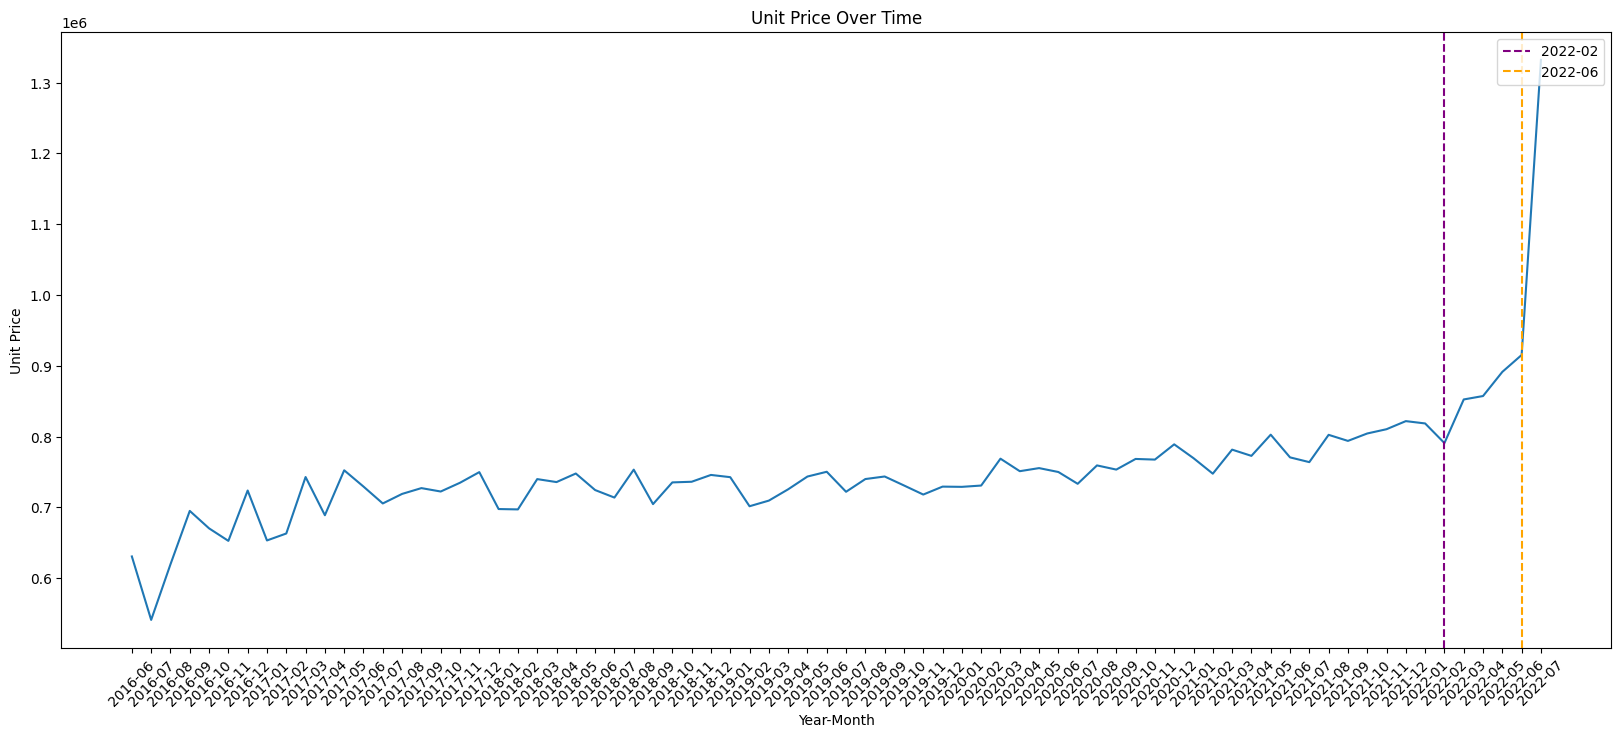

In [50]:
merged_unit['y_m'] = merged_unit['y_m'].astype(str)

# Plotting
plt.figure(figsize=(20, 8))

plt.plot(merged_unit['y_m'], merged_unit['unit_price'])

plt.xlabel('Year-Month')
plt.ylabel('Unit Price')
plt.title('Unit Price Over Time')

plt.xticks(rotation=45)
plt.axvline('2022-02', color='purple', linestyle='--', label='2022-02')
plt.axvline('2022-06', color='orange', linestyle='--', label='2022-06')
plt.legend(loc='upper right')

plt.show()

In [71]:
sales.booking_id.duplicated().sum()

0

## 월별 booking_id unique values

In [11]:
booking_cnt = sales.groupby('y_m')['booking_id'].nunique()
booking_cnt

y_m
2016-06        1
2016-07      296
2016-08      547
2016-09      717
2016-10      989
           ...  
2022-03    28801
2022-04    29237
2022-05    30084
2022-06    28587
2022-07    25162
Freq: M, Name: booking_id, Length: 74, dtype: int64

In [12]:
booking_cnt_df = booking_cnt.to_frame(name='booking_cnt').reset_index()
booking_cnt_df

,y_m,booking_cnt
0,2016-06,1
1,2016-07,296
2,2016-08,547
3,2016-09,717
4,2016-10,989
...,...,...
69,2022-03,28801
70,2022-04,29237
71,2022-05,30084
72,2022-06,28587


In [16]:
merged_unit = merged_unit.merge(booking_cnt_df, on='y_m')
merged_unit.tail(10)

,y_m,cus_cnt,sales,unit_price,booking_cnt_x,booking_cnt_y
64,2021-10,16391,13185763883,804451.46,24675,24675
65,2021-11,16785,13604234091,810499.50,25063,25063
66,2021-12,16800,13808231073,821918.52,25677,25677
67,2022-01,17881,14638115485,818640.76,27276,27276
68,2022-02,17143,13558884243,790928.32,25448,25448
69,2022-03,18236,15546610108,852523.04,28801,28801
70,2022-04,18449,15817357632,857355.83,29237,29237
71,2022-05,18089,16125996954,891480.84,30084,30084
72,2022-06,16815,15391398000,915337.38,28587,28587
73,2022-07,10223,13618235309,1332117.31,25162,25162
